# Syria Phenolopy

## Setup

In [46]:
import ee

# ee.Authenticate()
ee.Initialize()

In [47]:
import sys

sys.path.append(
    "C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/Phenolopy/scripts"
)
import phenolopy

In [48]:
sys.path.append(
    "C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/GEE_Zonal/src/gee_zonal"
)  # Replace with the actual path to the GEE_Zonal repository

In [49]:
import os
from os.path import join, expanduser

# sys.path.append(join(expanduser("~"), "Repos", "GEE_Zonal", "src"))

# Data
import geopandas as gpd
import pandas as pd

## Earth Engine APIs
import ee
import gee_zonal
from gee_helpers import gpd_to_gee

# from gee_zonal import gpd_to_gee
from geemap.conversion import *

import xarray as xr
from tqdm.notebook import tqdm
from dask.distributed import Client, LocalCluster
import requests

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format


# sys.path.append(join(expanduser("~"), "Repos", "phenolopy", "scripts"))
# import phenolopy

sys.path.append(join(expanduser("~"), "Repos", "GOSTrocks", "src"))

In [5]:
print(dir(gee_zonal))

['Catalog', 'ZonalStats', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'catalog', 'gee_helpers', 'zonalstats']


## Process Modis

In [50]:
start_period = ee.Date("2014-01-01")
end_period = ee.Date("2023-12-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")


def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}
lgrip30 = ee.ImageCollection(
    "projects/sat-io/open-datasets/GFSAD/LGRIP30"
).mosaic()  # .clip(geoj)
crop_data = lgrip30.select("b1").gt(1).rename("crop")

In [21]:
image = modis.first()
mean_band_values = image.reduceRegion(
    reducer=ee.Reducer.mean(),  # The reducer to apply (mean)
    geometry=aoi,  # The region over which to calculate the mean
    scale=250,  # The scale in meters (e.g., 10 meters for Sentinel-2)
    maxPixels=1e9,  # Maximum number of pixels to include in the calculation
)
print("Mean band values over the region:", mean_band_values.getInfo())

Mean band values over the region: {'EVI': 1229.21309365495}


## Admin

In [51]:
iso3 = "SYR"
country = "Syria"
release_type = "gbOpen"

adm = "ADM0"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm0_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM1"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm1_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM2"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm2_syr = gpd.read_file(res["gjDownloadURL"])

Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM0/geoBoundaries-SYR-ADM0.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM1/geoBoundaries-SYR-ADM1.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM2/geoBoundaries-SYR-ADM2.geojson


In [52]:
aoi = gpd_to_gee(adm0_syr)

### Labels

In [9]:
# labels = gpd.read_file(join(expanduser('~'), 'tmp', 'usgs', 'usgs-niger.shp'))
# labels = labels.loc[labels.land_use_t==1].copy()

In [ ]:
adm1_syr.explore()

## Pull Data

In [53]:
scale_factor = 0.0001


# apply cropland mask to imageCollection
def cropmask(img):
    return img.clip(aoi)  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)
# def cropmask(img):
#   return img.updateMask(crop_data).clip(aoi) #.multiply(scale_factor) # unmask(-1)

In [ ]:
"""# Function to create a mask of invalid (null/masked) pixels
def count_null_pixels(image):
    # Create a mask where valid pixels are 1 and null/masked pixels are 0
    null_mask = image.mask().Not()  # Masked (null) pixels will be True (1), valid pixels will be False (0)
    
    # Count the number of null pixels in the Area of Interest (AOI)
    null_pixel_count = null_mask.reduceRegion(
        reducer=ee.Reducer.sum(),  # Sum the number of null pixels
        geometry=aoi,  # Your AOI
        scale=250,  # MODIS scale
        maxPixels=1e13
    )
    
    return null_pixel_count

# Apply this function to check for null values in the first image
first_image = mxd13q1.first()
null_count_result = count_null_pixels(first_image)

# Print the result, showing the number of null pixels
print(null_count_result.getInfo())"""

In [ ]:
"""# Function to calculate null pixel count and total pixel count across the collection
def count_nulls_in_collection(img_collection):
    def count_null_pixels(image):
        # Create a mask for null (masked) pixels
        null_mask = image.mask().Not()
        
        # Calculate null pixel count (masked pixels)
        null_pixel_count = null_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=250,
            maxPixels=1e13
        )
        
        # Calculate total pixel count (all pixels, both masked and unmasked)
        total_pixel_count = ee.Image(1).reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=aoi,
            scale=250,
            maxPixels=1e13
        )
        
        # Set both null and total pixel counts as properties on the image
        return image.set(null_pixel_count).set(total_pixel_count)
    
    # Map the null-counting function over the collection
    return img_collection.map(count_null_pixels)

# Apply the function to your MODIS collection
mxd13q1_with_null_counts = count_nulls_in_collection(mxd13q1)

# Print the null counts and total pixel counts for the first image in the collection
print(mxd13q1_with_null_counts.first().getInfo())"""

In [ ]:
"""import ee

# Initialize the Earth Engine library
ee.Initialize()

# Define the start and end period
start_period = ee.Date("2020-01-01")
end_period = ee.Date("2024-08-30")

# Load MODIS Terra and Aqua Image Collections, select EVI band, and filter by date
terra = ee.ImageCollection("MODIS/061/MOD13Q1").select("EVI").filterDate(start_period, end_period)
aqua = ee.ImageCollection("MODIS/061/MYD13Q1").select("EVI").filterDate(start_period, end_period)

# Merge Terra and Aqua collections and sort by time
modis = terra.merge(aqua).sort("system:time_start")

# Define Area of Interest (AOI) - this is needed for the reduceRegion functions
# Replace this with your actual AOI geometry
#aoi = ee.Geometry.BBox(35, 32, 42, 37)  # Example bounding box for Syria

# Function to calculate null (masked) pixels and total pixels
def count_pixels(image):
    # Mask where null (masked) pixels are 1, and valid pixels are 0
    null_mask = image.mask().Not()

    # Count the number of null (masked) pixels
    null_pixel_count = null_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=250,  # MODIS scale
        maxPixels=1e13
    )

    # Count the total number of pixels (including valid and null)
    total_pixel_count = ee.Image(1).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=aoi,
        scale=250,
        maxPixels=1e13
    )

    # Set the null and total counts as properties on the image
    return image.set(null_pixel_count).set(total_pixel_count)

# Apply the pixel-counting function to the MODIS collection
modis_with_counts = modis.map(count_pixels)

# Get the first image in the collection and print the null and total pixel counts
first_image_counts = modis_with_counts.first().getInfo()

# Extract and print the counts
print("Null pixel count:", first_image_counts['properties'].get('sum'))
print("Total pixel count:", first_image_counts['properties'].get('count'))

# You can loop through the collection to print for each image if necessary"""

In [54]:
# Specify the path to your GeoJSON file
file_path = "C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/data/boundaries/geoBoundaries-SYR-ADM2.geojson"
# Read the GeoJSON file into a GeoDataFrame
adm2_syr_sel = gpd.read_file(file_path)

## Map

In [23]:
# Select the first administrative boundary of Syria at the ADM2 level
one = adm2_syr_sel.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]

# Symbology for visualizing vegetation indices
viVis = {
    "min": 0.0,
    "max": 8000.0,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}

# Symbology for normalized values (e.g., NDVI between 0 and 1)
viVis2 = {
    "min": 0,
    "max": 1,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}

In [14]:
"""one = adm2_ner_sel.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]

# Symbology
viVis = {
    "min": 0.0,
    "max": 8000.0,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}
# Symbology
viVis2 = {
    "min": 0,
    "max": 1,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}"""

'one = adm2_ner_sel.iloc[[0]]\ncentx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]\n\n# Symbology\nviVis = {\n    "min": 0.0,\n    "max": 8000.0,\n    "palette": [\n        "FFFFFF",\n        "CE7E45",\n        "DF923D",\n        "F1B555",\n        "FCD163",\n        "99B718",\n        "74A901",\n        "66A000",\n        "529400",\n        "3E8601",\n        "207401",\n        "056201",\n        "004C00",\n        "023B01",\n        "012E01",\n        "011D01",\n        "011301",\n    ],\n}\n# Symbology\nviVis2 = {\n    "min": 0,\n    "max": 1,\n    "palette": [\n        "FFFFFF",\n        "CE7E45",\n        "DF923D",\n        "F1B555",\n        "FCD163",\n        "99B718",\n        "74A901",\n        "66A000",\n        "529400",\n        "3E8601",\n        "207401",\n        "056201",\n        "004C00",\n        "023B01",\n        "012E01",\n        "011D01",\n        "011301",\n    ],\n}'

In [ ]:
import geemap

m = geemap.Map(center=[centy, centx], zoom=10)
m.add_basemap("Esri.WorldImagery")
m.addLayer(modis.select("EVI").first().clip(aoi), viVis, "Raw VI")
m.addLayer(mxd13q1.select("EVI").first(), viVis, "VI")
m.addLayerControl()
m

In [56]:
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

In [58]:
utm = "EPSG:32636"  #'EPSG:32637' #'SR-ORG:6974' #"EPSG:4326" #"EPSG:32637" #"EPSG:4326" #"EPSG:32632"  # 'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'

In [ ]:
"""# Define the CRS (coordinate reference system) and scale factor for EVI
utm = 'EPSG:32633'  # Replace with the appropriate CRS if necessary
scale_factor = 0.0001
years = range(2020, 2021)  # Define the years of interest
months = range(1, 13)  # Define the months of interest

# MODIS EVI datasets for Terra (MOD13Q1) and Aqua (MYD13Q1)
modis_merged_evi = terra.select("EVI").merge(aqua.select("EVI"))

#Function to split the AOI into smaller tiles
def split_aoi_into_tiles(aoi, scale):
    # This creates a grid of smaller geometries (tiles) over the AOI
    grid = aoi.coveringGrid(scale)
    return grid

# Split the AOI into smaller tiles (using a scale of 5000 meters for each tile)
tile_scale = 5000
smaller_aois = split_aoi_into_tiles(aoi, tile_scale)

# Container for raw datasets
ds_all = []

for year in tqdm(years):
    for month in tqdm(months):
        # Filter the merged collection by year and month
        modis_filtered = modis_merged_evi.filter(ee.Filter.calendarRange(year, year, "year")) \
                                         .filter(ee.Filter.calendarRange(month, month, "month")) \
                                         .first()  # Get the first image for the specified month
        
        # Select the EVI band and clip to the AOI
        evi = modis_filtered.select('EVI').clip(aoi)

        # Sample the raw EVI data over the AOI as pixel values (without reduction)
        evi_values = evi.sampleRectangle(region=aoi)

        # Get the EVI grid data and scale it
        evi_data = evi_values.getInfo()['properties']
        
        # Apply scale factor
        for key in evi_data:
            evi_data[key] = [[value * scale_factor for value in row] for row in evi_data[key]]
        
        # Append raw data for the month to the list
        ds_all.append({
            'year': year,
            'month': month,
            'evi_data': evi_data
        })

# Convert the results into a DataFrame or continue storing them for further analysis
print("Raw EVI Data stored.")"""

In [ ]:
import random

aoi_geometry = aoi.geometry()


# Function to generate random points within the AOI
def generate_random_points(aoi, num_points=10):
    # Create an empty list to store random points
    points = []

    # Get the bounds of the AOI (min/max lat/lon)
    bounds = aoi_geometry().bounds().getInfo()["coordinates"][0]
    min_lon = min([point[0] for point in bounds])
    max_lon = max([point[0] for point in bounds])
    min_lat = min([point[1] for point in bounds])
    max_lat = max([point[1] for point in bounds])

    # Generate random points within the bounds of the AOI
    for _ in range(num_points):
        random_lon = random.uniform(min_lon, max_lon)
        random_lat = random.uniform(min_lat, max_lat)
        random_point = ee.Geometry.Point([random_lon, random_lat])

        # Ensure the point is within the AOI
        if aoi.contains(random_point).getInfo():
            points.append(random_point)

    return points


# Generate 10 random points within the AOI
random_points = generate_random_points(aoi_geometry)

# Load the MODIS EVI image collection
modis = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select("EVI")
    .filterDate("2020-01-01", "2020-12-31")
)

# Select the first image (or any specific date)
first_image = modis.first()

# Loop through the random points and print the EVI values for each point
for i, point in enumerate(random_points):
    # Get the EVI value at the current point
    evi_value = first_image.reduceRegion(
        reducer=ee.Reducer.mean(),  # Use the mean reducer to get the value
        geometry=point,
        scale=250,  # Scale should match the resolution of the image
        maxPixels=1e13,
    )

    # Print the EVI value for the point
    print(
        f"Point {i + 1}: EVI value at {point.getInfo()['coordinates']}: {evi_value.getInfo()}"
    )

In [59]:
ds_all = []
scale_factor = 0.0001
years = range(2020, 2022)
months = range(1, 13)
for year in tqdm(years):
    for month in tqdm(months):
        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(
            ee.Filter.calendarRange(month, month, "month")
        )

        # ChildProcessError# modis_sel = mxd13q1.filterDate(f'{year}-{month}-01', f'{year}-{month+1}-01')
        ds = xr.open_dataset(
            modis_sel,
            engine="ee",
            geometry=aoi.geometry(),
            crs=utm,
            scale=250,
        )
        ds = ds * scale_factor
        ds = ds.compute()
        ds_all.append(ds)
    # print(f"Finished {year}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
modis_sel.toArray()

In [37]:
evi_sample = modis_sel.mean().reduceRegion(
    reducer=ee.Reducer.mean(),  # You can also use other reducers like 'first', 'median', etc.
    geometry=aoi.geometry(),  # Apply the reduction over a region
    scale=250,  # MODIS resolution is 500 meters
    maxPixels=1e9,
)

evi_value = evi_sample.get("EVI").getInfo()

# Step 7: Put the value into a Python list
evi_value_list = [evi_value]

# Step 8: Print the list
print("EVI values in the list:", evi_value_list)

EVI values in the list: [911.5673951775567]


In [38]:
ds_all[1].mean()

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    EVI      float32 4B nan

In [ ]:
"""import ee
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

# Initialize Earth Engine
ee.Initialize()

# Load the shapefile (replace 'adm0_shapefile.shp' with the actual file path)
adm0_shapefile = 'path_to_your_shapefile/adm0_shapefile.shp'
gdf = gpd.read_file(adm0_shapefile)

# Select the AOI (you can filter by country or region, here I'm taking the first geometry)
# Assuming you want to analyze the entire region defined in the shapefile
aoi_geometry = gdf.geometry[0]

# Convert GeoPandas geometry to an Earth Engine geometry object
aoi_ee = ee.Geometry.Polygon(list(aoi_geometry.exterior.coords))

# Define the CRS (coordinate reference system) and scale factor
utm = 'EPSG:32633'
scale_factor = 0.0001
years = range(2020, 2021)
months = range(1, 13)

# MODIS NDVI dataset
modis_ndvi = ee.ImageCollection("MODIS/006/MOD13Q1")

# Container for results
results_list = []

for year in tqdm(years):
    for month in tqdm(months):
        # Filter by year and month
        modis_filtered = modis_ndvi.filter(ee.Filter.calendarRange(year, year, "year")) \
                                   .filter(ee.Filter.calendarRange(month, month, "month")) \
                                   .first()  # Take the first image of the month
        
        # Select the NDVI band and clip to AOI
        ndvi = modis_filtered.select('NDVI').clip(aoi_ee)

        # Reduce region by mean and scale the result
        ndvi_reduced = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi_ee,
            scale=250,
            crs=utm
        )
        
        # Get the result from Earth Engine and scale
        ndvi_value = ndvi_reduced.getInfo().get('NDVI', None)  # None if no data available
        if ndvi_value is not None:
            ndvi_value *= scale_factor
        
        # Store results
        results_list.append({
            'year': year,
            'month': month,
            'ndvi': ndvi_value
        })

# Convert the results into a Pandas DataFrame for further analysis
df_results = pd.DataFrame(results_list)
print(df_results)"""

In [17]:
print(ds_all)

[<xarray.Dataset> Size: 64B
Dimensions:  (time: 4, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2015-01-01 2015-01-09 ... 2015-01-25
  * lon      (lon) float64 8B 160.7
  * lat      (lat) float64 8B 157.3
Data variables:
    EVI      (time, lon, lat) float32 16B nan nan nan nan
Attributes:
    crs:      EPSG:4326, <xarray.Dataset> Size: 64B
Dimensions:  (time: 4, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2015-02-02 2015-02-10 ... 2015-02-26
  * lon      (lon) float64 8B 160.7
  * lat      (lat) float64 8B 157.3
Data variables:
    EVI      (time, lon, lat) float32 16B nan nan nan nan
Attributes:
    crs:      EPSG:4326, <xarray.Dataset> Size: 64B
Dimensions:  (time: 4, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2015-03-06 2015-03-14 ... 2015-03-30
  * lon      (lon) float64 8B 160.7
  * lat      (lat) float64 8B 157.3
Data variables:
    EVI      (time, lon, lat) float32 16B nan nan nan nan
Attributes:
    crs:  

In [163]:
ds = xr.concat(ds_all, dim="time")

In [95]:
# ds.to_netcdf('C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\notebooks\\vegetation-conditions\\modis_evi_2014_2024.nc')

## Load Xarray Data

In [100]:
base_path = (
    "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"
)
ds_path = os.path.join(
    base_path, "notebooks", "vegetation-conditions", "modis_evi_2020_2024.nc"
)
ds = xr.open_dataset(ds_path)  # maradi
# ds = ds.isel(time=range(0,23))

In [101]:
size_in_bytes = ds.nbytes


def human_readable_size(size_in_bytes):
    # Convert size to a human-readable format
    for unit in ["bytes", "KB", "MB", "GB", "TB"]:
        if size_in_bytes < 1024:
            return f"{size_in_bytes:.2f} {unit}"
        size_in_bytes /= 1024


# Get the human-readable size of the dataset
readable_size = human_readable_size(size_in_bytes)
print(f"Size of the dataset: {readable_size}")

Size of the dataset: 2.17 KB


In [102]:
print(ds)

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 184, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2020-01-01 2020-01-09 ... 2023-12-27
  * lon      (lon) float64 8B 160.7
  * lat      (lat) float64 8B 157.3
Data variables:
    EVI      (time, lon, lat) float32 736B ...
Attributes:
    crs:      EPSG:4326


In [ ]:
"""ds_path_2 = os.path.join(base_path,'notebooks', 'vegetation-conditions', 'modis_evi_2018_2024.nc')
ds_temp = xr.open_dataset(ds_path_2)
print(ds_temp.isnull().sum())"""

In [ ]:
"""if 'EVI' in ds_temp.variables:
    evi_data = ds_temp['EVI']
    print(evi_data)

    # Step 4: View specific values (e.g., for a particular time or location)
    # Example: Access EVI values for a specific time and location
    print(evi_data.values)  # Shows all EVI values in the array

    # Example: Access EVI for a specific time (if it is time-indexed)
    if 'time' in ds_temp.dims:
        print("EVI at time index 0:", evi_data.isel(time=0).values)
else:
    print("EVI variable not found in this dataset.")"""

## Dask Prep

In [103]:
import multiprocessing

multiprocessing.cpu_count()

8

In [104]:
# Dask Prep
workers = 30
cluster = LocalCluster(n_workers=workers)
client = Client(cluster)
client

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49237 instead
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.44s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49237/status,
Dashboard: http://127.0.0.1:49237/status,Workers: 30
Total threads: 30,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49238,Workers: 30
Dashboard: http://127.0.0.1:49237/status,Total threads: 30
Started: Just now,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:49346,Total threads: 1
Dashboard: http://127.0.0.1:49349/status,Memory: 524.58 MiB
Nanny: tcp://127.0.0.1:49241,


2024-10-12 22:23:35,654 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:49305', name: 5, status: running, memory: 0, processing: 0>
2024-10-12 22:23:35,688 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:49312', name: 20, status: running, memory: 0, processing: 0>
2024-10-12 22:23:35,701 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:49313', name: 21, status: running, memory: 0, processing: 0>
2024-10-12 22:23:35,782 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:49316', name: 14, status: running, memory: 0, processing: 0>
2024-10-12 22:23:35,913 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:49329', name: 17, stat

In [58]:
# client.restart()

In [148]:
# client.close()
# client.shutdown()

## Phenolopy

In [ ]:
"""# Already ran all this
dask_chunks={"time": -1, "lon": 500, "lat": 500}
ds = ds.chunk(dask_chunks)
ds = ds.rename_vars({'EVI':'veg_index'})
ds = phenolopy.remove_outliers(ds=ds, method='median', user_factor=2, z_pval=0.05)
print("Finished removing outliers")
ds = ds.chunk(dask_chunks)
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')
ds = phenolopy.smooth(ds=ds, method='savitsky', window_length=3, polyorder=1)
ds = ds.compute()"""

In [ ]:
"""import numpy as np

# Chunk the dataset for efficient Dask processing
dask_chunks = {"time": -1, "X": 500, "Y": 500}
ds = ds.chunk(dask_chunks)

# Rename the 'EVI' variable to 'veg_index'
ds = ds.rename_vars({'EVI': 'veg_index'})

# Remove outliers using Phenolopy's function (replacing the use of xarray's deprecated ufuncs with NumPy functions)
ds = phenolopy.remove_outliers(ds=ds, method='median', user_factor=2, z_pval=0.05)
print("Finished removing outliers")

# Re-chunk the dataset after removing outliers
ds = ds.chunk(dask_chunks)

# Interpolate missing data points using the specified method
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')

# Smooth the dataset using the Savitzky-Golay filter method
ds = phenolopy.smooth(ds=ds, method='savitsky', window_length=3, polyorder=1)

# Trigger the computation to finalize the result
ds = ds.compute()"""

In [118]:
for val in ds["EVI"]:
    print(val.values)

[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]
[[nan]]


In [114]:
ds_all = []
years = range(2020, 2024)  # 2001 2024
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year == year)
    dask_chunks = {"time": -1, "lon": 500, "lat": 500}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({"EVI": "veg_index"})
    ds_sel = phenolopy.remove_outliers(
        ds=ds_sel, method="median", user_factor=2, z_pval=0.05
    )
    ds_sel = ds_sel.chunk(dask_chunks)
    # ds_sel = phenolopy.interpolate(ds=ds_sel, method="interpolate_na")
    # ds_sel = phenolopy.smooth(
    # ds=ds_sel, method="savitsky", window_length=3, polyorder=1
    # )
    ds_sel = ds_sel.compute()
    ds_all.append(ds_sel)
    print(f"Finished {year}")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



 25%|██▌       | 1/4 [00:25<01:17, 25.92s/it]

Finished 2020
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



 50%|█████     | 2/4 [00:54<00:54, 27.28s/it]

Finished 2021
Outlier removal method: median with a user factor of: 2


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



 75%|███████▌  | 3/4 [01:17<00:25, 25.53s/it]

Finished 2022
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



100%|██████████| 4/4 [01:44<00:00, 26.18s/it]

Finished 2023


In [115]:
print(ds_all[0])

<xarray.Dataset> Size: 568B
Dimensions:    (time: 46, lon: 1, lat: 1)
Coordinates:
  * time       (time) datetime64[ns] 368B 2020-01-01 2020-01-09 ... 2020-12-26
  * lon        (lon) float64 8B 160.7
  * lat        (lat) float64 8B 157.3
Data variables:
    veg_index  (time, lon, lat) float32 184B nan nan nan nan ... nan nan nan nan


In [73]:
ds_all = []
years = range(2014, 2024)  # 2001 2024
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year == year)
    dask_chunks = {"time": -1, "lon": 500, "lat": 500}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({"EVI": "veg_index"})
    ds_sel = phenolopy.remove_outliers(
        ds=ds_sel, method="median", user_factor=2, z_pval=0.05
    )
    ds_sel = ds_sel.chunk(dask_chunks)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


 10%|█         | 1/10 [00:00<00:04,  2.21it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 20%|██        | 2/10 [00:00<00:02,  2.69it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 30%|███       | 3/10 [00:01<00:02,  2.56it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 40%|████      | 4/10 [00:01<00:02,  2.53it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 60%|██████    | 6/10 [00:02<00:01,  2.66it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 80%|████████  | 8/10 [00:03<00:00,  2.16it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
 90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [74]:
ds_sel = phenolopy.interpolate(ds=ds_sel, method="interpolate_na")

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.



In [84]:
print(ds_sel)

<xarray.Dataset> Size: 568B
Dimensions:    (time: 46, lon: 1, lat: 1)
Coordinates:
  * time       (time) datetime64[ns] 368B 2023-01-01 2023-01-09 ... 2023-12-27
  * lon        (lon) float64 8B 160.7
  * lat        (lat) float64 8B 157.3
Data variables:
    veg_index  (time, lon, lat) float32 184B dask.array<chunksize=(46, 1, 1), meta=np.ndarray>


In [76]:
print(ds_sel.isnull().sum())

<xarray.Dataset> Size: 8B
Dimensions:    ()
Data variables:
    veg_index  int64 8B dask.array<chunksize=(), meta=np.ndarray>


In [77]:
null_counts = ds_sel.isnull().sum().compute()

# Print the null counts
print(null_counts)

<xarray.Dataset> Size: 8B
Dimensions:    ()
Data variables:
    veg_index  int64 8B 46


In [82]:
# Total number of values in the dataset (includes null and non-null)
total_values = ds_sel.size

# Compute the number of null (NaN) values in the dataset
null_counts = ds_sel.isnull().sum().compute()

# Calculate the number of valid (non-null) values
valid_values = (
    total_values - null_counts["veg_index"].values
)  # Assuming 'veg_index' is your variable

# Print the results
print(f"Total values: {total_values}")
print(f"Null values: {null_counts['veg_index'].values}")
print(f"Valid (non-null) values: {valid_values}")

AttributeError: 'Dataset' object has no attribute 'size'

In [71]:
ds_sel = phenolopy.smooth(ds=ds_sel, method="savitsky", window_length=5, polyorder=1)

Smoothing method: savitsky with window length: 5 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



In [72]:
ds_sel = ds_sel.compute()

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
ds_all.append(ds_sel)
print(f"Finished {year}")

In [53]:
from dask.distributed import Client, LocalCluster
from tqdm import tqdm

# Set up the Dask cluster with optimized resources
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit="4GB")
client = Client(cluster)

ds_all = []
years = range(2020, 2023)  # Processing data from 2014 to 2023
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year == year)
    if len(ds_sel["time"]) == 0:
        print(f"No data available for the year {year}")
        continue  # Skip the iteration if there is no data

    dask_chunks = {"time": -1, "lon": 250, "lat": 250}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({"EVI": "veg_index"})

    # Handle missing values before smoothing
    ds_sel = ds_sel.fillna(
        0
    )  # Replace NaN values with zeros or other appropriate values

    ds_sel = phenolopy.remove_outliers(
        ds=ds_sel, method="median", user_factor=2, z_pval=0.05
    )
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = phenolopy.interpolate(ds=ds_sel, method="interpolate_na")

    # Adjusted smoothing parameters for stability
    ds_sel = phenolopy.smooth(
        ds=ds_sel, method="savitsky", window_length=5, polyorder=2
    )

    ds_sel = ds_sel.compute()
    ds_all.append(ds_sel)
    print(f"Finished processing for the year {year}")

# Close the Dask client after processing is complete
# client.close()

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61141 instead
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.08s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 5 and polyorder: 2.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



 33%|███▎      | 1/3 [00:05<00:10,  5.06s/it]

Finished processing for the year 2020
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 5 and polyorder: 2.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



 67%|██████▋   | 2/3 [00:07<00:03,  3.38s/it]

Finished processing for the year 2021
Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 5 and polyorder: 2.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



100%|██████████| 3/3 [00:08<00:00,  2.79s/it]

Finished processing for the year 2022


2024-10-12 22:23:35,238 - distributed.scheduler - WARNING - Worker failed to heartbeat for 430s; attempting restart: <WorkerState 'tcp://127.0.0.1:61162', name: 1, status: running, memory: 0, processing: 0>
2024-10-12 22:23:40,067 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-12 22:23:42,283 - distributed.nanny - WARNING - Restarting worker


In [70]:
# ds.to_netcdf(join(data_dir, "modis_niger_processed.nc"))

In [47]:
ds = ds.compute()

In [54]:
# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(
    da=ds["EVI"],
    peak_metric="pos",
    base_metric="vos",
    method="seasonal_amplitude",
    factor=0.2,
    thresh_sides="two_sided",
)
# abs_value=0.1)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast


In [73]:
# df_2023 = df.copy()

In [55]:
df = ds_phenos.to_dataframe()
df.reset_index(inplace=True)
df.drop(columns=["time"], inplace=True)

In [56]:
df.loc[:, "count_na"] = df.isna().sum(axis=1)

In [57]:
df.head()

,lon,lat,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,...,eos_values,eos_times,los_values,roi_values,rod_values,lios_values,sios_values,liot_values,siot_values,count_na
0,160.716569,157.311354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18


In [58]:
df = df.loc[df.count_na < 18].copy()

In [59]:
len(df.loc[~df.sos_values.isna()]) / len(df)

ZeroDivisionError: division by zero

In [38]:
len(df.loc[~df.sos_values.isna()]) / len(df)

ZeroDivisionError: division by zero

In [62]:
# df_2022 = df.copy()

In [39]:
df.to_csv(join(data_dir, "ner_pixels_phenos.csv"), index=False)

## Get Training Data

In [79]:
labels = gpd.read_file(
    join(expanduser("~"), "data", "niger", "sahel_training_data_20211110.geojson")
)
labels.Class.value_counts()

Class
0    3961
1    2246
Name: count, dtype: int64

In [82]:
adm0_ner.crs == labels.crs

True

In [83]:
labels = labels.loc[labels.intersects(adm0_ner.geometry.iloc[0])].copy()
labels.Class.value_counts()

Class
0    340
1    262
Name: count, dtype: int64

In [84]:
labels = labels.to_crs(utm)
labels.loc[:, "geometry"] = labels.geometry.centroid

In [85]:
adm2_ner = adm2_ner.to_crs(utm)

In [90]:
res = []
for idx, row in tqdm(labels.iterrows()):
    geom = row.geometry
    x = geom.x
    y = geom.y
    # x, y = row['geometry'].coords[0]
    ds_sel = ds_phenos.sel(y=y, x=x, method="nearest")

    s = ds_sel.to_pandas()
    s.name = idx
    s["X"] = ds_sel.x.values
    s["Y"] = ds_sel.y.values
    s["class"] = int(row.Class)
    s["geometry"] = geom
    try:
        s["adm2"] = adm2_ner.loc[adm2_ner.geometry.contains(geom)].iloc[0]["shapeName"]
    except:
        s["adm2"] = None
    df_sample = s.to_frame().transpose()

    # df = ds_sel.to_dataframe()
    # df.loc[:, 'id_sample'] = idx
    res.append(df_sample)

0it [00:00, ?it/s]

In [91]:
df_labels = pd.concat(res)

In [97]:
df_labels = df_labels.loc[~df_labels.sos_values.isna()].copy()

In [99]:
df_labels = df_labels.loc[df_labels["class"] == 1].copy()

In [101]:
df_evi = ds.veg_index.to_dataframe().reset_index()
df_evi = df_evi.loc[~df_evi.veg_index.isna()].copy()

In [120]:
df_labels.sos_times = df_labels.sos_times.astype("int")
df_labels.eos_times = df_labels.eos_times.astype("int")
df_labels.pos_times = df_labels.pos_times.astype("int")
df_labels.vos_times = df_labels.vos_times.astype("int")

In [121]:
df_labels.loc[:, "sos_times_dt"] = pd.to_datetime(
    df_labels.sos_times, unit="D", origin="2023-01-01"
)
df_labels.loc[:, "eos_times_dt"] = pd.to_datetime(
    df_labels.eos_times, unit="D", origin="2023-01-01"
)
df_labels.loc[:, "pos_times_dt"] = pd.to_datetime(
    df_labels.pos_times, unit="D", origin="2023-01-01"
)
df_labels.loc[:, "vos_times_dt"] = pd.to_datetime(
    df_labels.vos_times, unit="D", origin="2023-01-01"
)

In [122]:
df_evi.head(2)

,time,y,x,spatial_ref,veg_index
2764235,2023-01-01,2.515554e+06,1.075167e+06,0,0.08415
5004061,2023-01-01,2.432304e+06,1.008917e+06,0,0.07990


In [123]:
df_labels.head(2)

,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,sos_times,eos_values,...,siot_values,X,Y,class,geometry,adm2,sos_times_dt,eos_times_dt,pos_times_dt,vos_times_dt
2950,0.306367,241,0.283726,0.122833,145,0.133517,0.183533,0.1598,177,0.1599,...,2.082128,-58583.45273828611,1436803.8511287074,1,POINT (-58600.04989250092 1436880.347114694),Tibiri,2023-06-27,2023-11-10,2023-08-30,2023-05-26
2959,0.353967,265,0.333585,0.121333,145,0.15195,0.232633,0.175567,185,0.182567,...,3.74506,-103333.45273828611,1418553.8511287074,1,POINT (-103399.43236968899 1418441.980538326),Dosso,2023-07-05,2023-12-12,2023-09-23,2023-05-26


In [125]:
one = df_labels.iloc[[0]]
one

,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,sos_times,eos_values,...,siot_values,X,Y,class,geometry,adm2,sos_times_dt,eos_times_dt,pos_times_dt,vos_times_dt
2950,0.306367,241,0.283726,0.122833,145,0.133517,0.183533,0.1598,177,0.1599,...,2.082128,-58583.45273828611,1436803.8511287074,1,POINT (-58600.04989250092 1436880.347114694),Tibiri,2023-06-27,2023-11-10,2023-08-30,2023-05-26


In [126]:
df_evi_sel = df_evi.loc[df_evi.x == one.X.iloc[0]].loc[df_evi.y == one.Y.iloc[0]].copy()

In [128]:
df_evi_sel.loc[:, "ymd"] = pd.to_datetime(df_evi_sel.time.dt.strftime("%Y-%m-%d"))

In [131]:
font = "Liberation Sans"

In [136]:
ds = xr.open_dataset(join(data_dir, "modis_crop_dea.nc"))
ds
ds = ds.sel(time=ds.time.dt.year == 2023)
# ds = ds.sel(time=ds.time.dt.year==2022)

In [138]:
ds = ds.compute()

In [140]:
df_evi_raw = ds.EVI.to_dataframe().reset_index()
df_evi_raw = df_evi_raw.loc[~df_evi_raw.EVI.isna()].copy()

In [141]:
df_evi_raw.head(2)

,time,X,Y,EVI
239870,2023-01-01,-454833.452738,1.623054e+06,0.1232
250355,2023-01-01,-454333.452738,1.622804e+06,0.1311


In [142]:
df_evi_raw_sel = (
    df_evi_raw.loc[df_evi_raw.X == one.X.iloc[0]]
    .loc[df_evi_raw.Y == one.Y.iloc[0]]
    .copy()
)

In [143]:
df_evi_raw_sel.loc[:, "ymd"] = pd.to_datetime(
    df_evi_raw_sel.time.dt.strftime("%Y-%m-%d")
)

In [145]:
charts_dir = join(expanduser("~"), "Repos", "niger")

In [146]:
# id_sel = 25893
p = (
    ggplot(df_evi_raw_sel, aes(x="ymd", y="EVI"))
    + geom_point(alpha=0.75, color="#006d2c")
    + geom_line(
        df_evi_sel, aes(x="ymd", y="veg_index"), alpha=1, size=1.5, color="black"
    )
    + geom_vline(xintercept=one["sos_times_dt"].iloc[0], linetype="dashed", color="red")
    + geom_vline(xintercept=one["eos_times_dt"].iloc[0], linetype="dashed", color="red")
    + geom_vline(xintercept=one["pos_times_dt"].iloc[0], linetype="dashed", color="red")
    # + geom_vline(xintercept=df.loc[df.id==id_sel, "vos_times_dt"].iloc[0], linetype="dashed", color="red")
    + labs(
        x="",
        subtitle="EVI",
        title="EVI for a sample point",
        y="",
        caption="Source: MODIS",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)
p.save(
    filename=join(charts_dir, "evi-phenology.jpeg"),
    dpi=300,
)

/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/rtmis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/jupyter-wb514197/Repos/niger/evi-phenology.jpeg


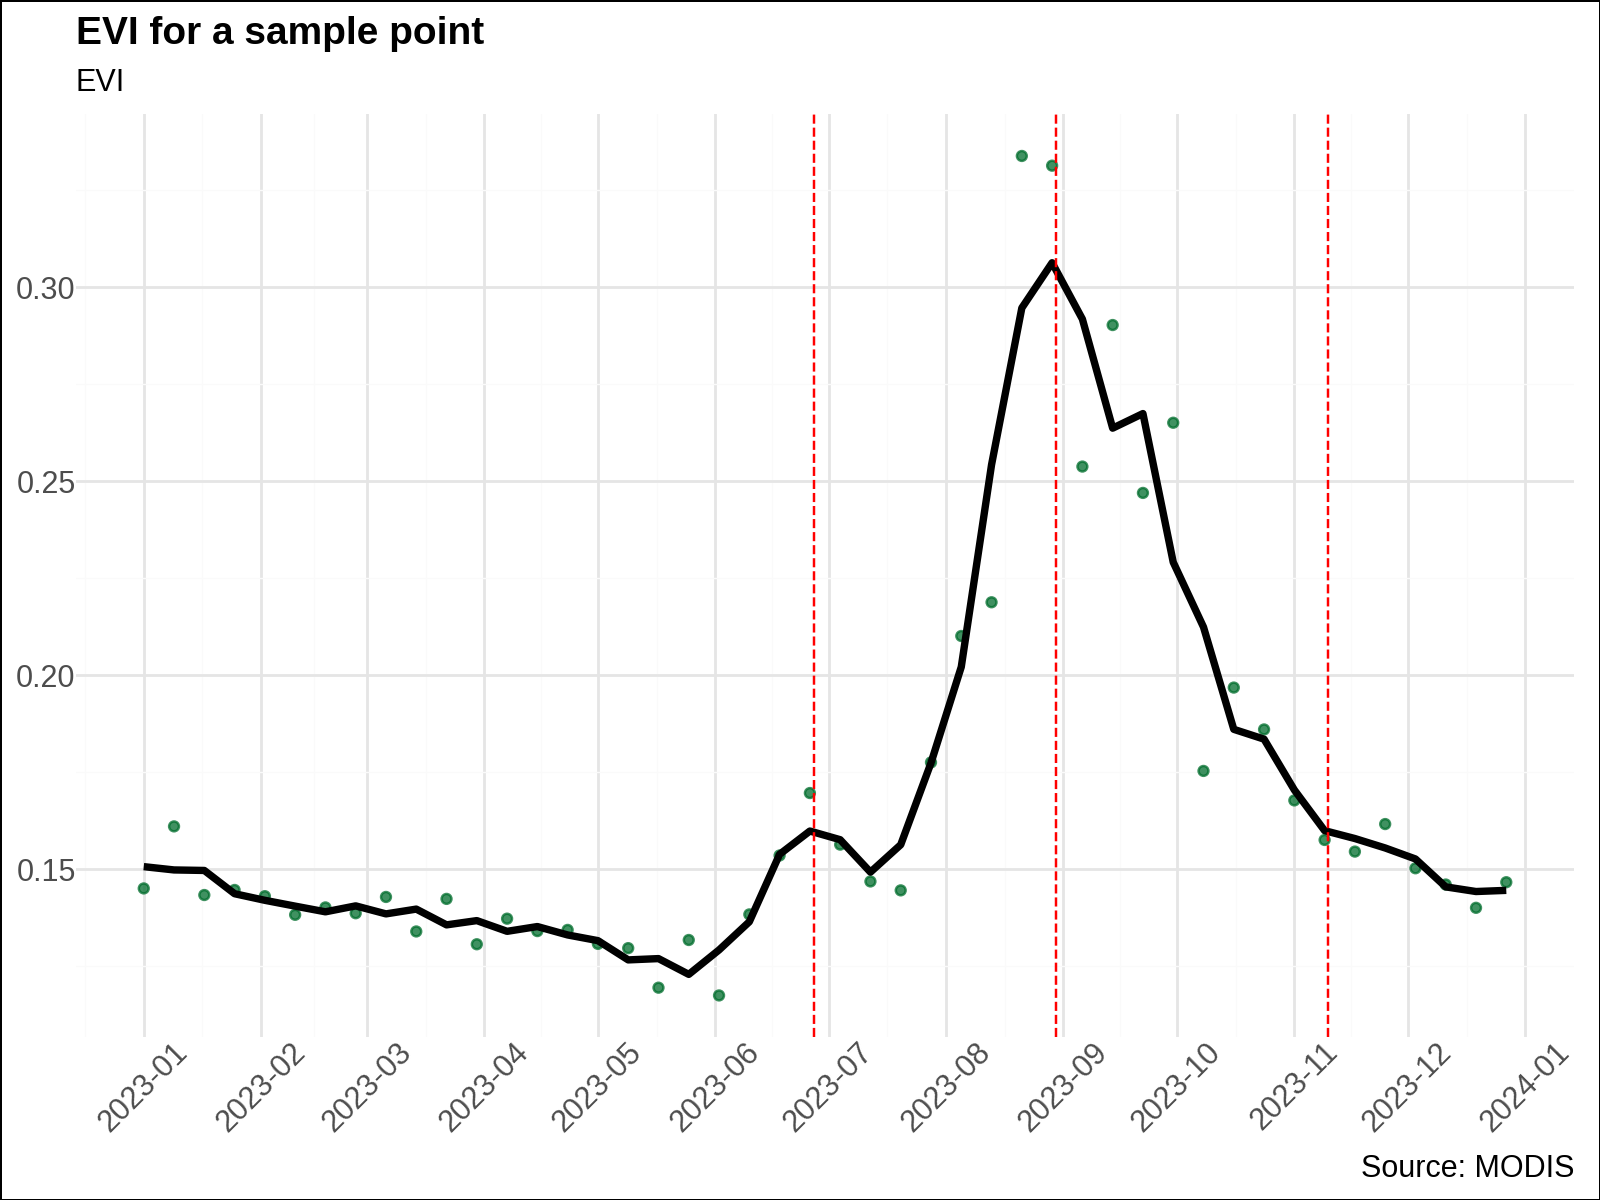

In [147]:
p

In [106]:
gdf_labels = gpd.GeoDataFrame(df_labels, geometry="geometry", crs=utm)
gdf_sel = gdf_labels.loc[gdf_labels.adm2.isna()].copy()

In [110]:
gdf_sel

,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,sos_times,eos_values,...,rod_values,lios_values,sios_values,liot_values,siot_values,X,Y,class,geometry,adm2
4486,0.385517,257.0,0.360789,0.141633,353.0,0.143167,0.243883,0.1852,169.0,0.1969,...,0.003368,4.95385,2.262818,9.593398,3.219896,-139833.4527382861,1349303.8511287074,0,POINT (-139749.246 1349390.147),None
6031,0.2811,233.0,0.261532,0.120867,129.0,0.1356,0.160233,0.160267,185.0,0.154733,...,0.001316,4.1406,1.844133,7.7583,2.319297,172416.5472617139,1519053.8511287074,1,POINT (172507.779 1519049.092),None


In [129]:
# import folium as flm
# m = gdf_sel[['class', 'geometry']].explore()
# adm2_ner.explore(m=m)
# flm.LayerControl().add_to(m)
# m

In [130]:
df_labels.loc[6031, "adm2"] = "Madaoua"
df_labels.loc[4486, "adm2"] = "Dosso"

## Classification Model

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [144]:
# df_labels['class']

In [139]:
df_labels.loc[:, "crop"] = df_labels["class"].astype(int)

In [141]:
df_labels.drop(columns=["class"], inplace=True)

In [142]:
df_samples = df_labels.copy()

In [167]:
df_samples.fillna(0, inplace=True)

In [182]:
df_samples.loc[df_samples.isna().any(axis=1)][["sos_values", "sos_times", "crop"]]

,sos_values,sos_times,crop


In [183]:
df_samples.columns

Index(['pos_values', 'pos_times', 'mos_values', 'vos_values', 'vos_times',
       'bse_values', 'aos_values', 'sos_values', 'sos_times', 'eos_values',
       'eos_times', 'los_values', 'roi_values', 'rod_values', 'lios_values',
       'sios_values', 'liot_values', 'siot_values', 'X', 'Y', 'geometry',
       'adm2', 'crop'],
      dtype='object')

In [184]:
subset = [
    "sos_values",
    "sos_times",
    "eos_values",
    "eos_times",
    "pos_values",
    "pos_times",
    "los_values",
]

In [185]:
y = df_samples["crop"]
X = df_samples.loc[:, subset]
# X = df_samples.loc[:,'pos_values':'siot_values']

In [186]:
y.value_counts()

crop
0    340
1    262
Name: count, dtype: int64

In [187]:
X.isna().sum()

sos_values    0
sos_times     0
eos_values    0
eos_times     0
pos_values    0
pos_times     0
los_values    0
dtype: int64

In [188]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=100, stratify=df_samples.loc[:, ("crop")]
)

In [189]:
rf_pipeline = Pipeline([("rf", RandomForestClassifier())])
rf_params = {
    "rf__n_estimators": (100, 1000, 5000),
    "rf__criterion": ("gini", "entropy"),
    "rf__max_depth": (1, 3, 5),
    "rf__min_samples_split": (2, 5, 10),
    "rf__random_state": [10],
}
k = 2

rf_grid_model = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=k,
    scoring=["accuracy", "precision", "recall"],
    refit="accuracy",
)

crop_fitted = rf_grid_model.fit(X_train, y_train.ravel())
crop_results = crop_fitted.cv_results_
crop_results = pd.DataFrame(crop_results)

In [190]:
params = crop_results.sort_values("mean_test_accuracy", ascending=False).iloc[0][
    "params"
]
params

{'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 100,
 'rf__random_state': 10}

In [192]:
criterion = params["rf__criterion"]
max_depth = params["rf__max_depth"]
min_samples_split = params["rf__min_samples_split"]
n_estimators = params["rf__n_estimators"]
random_state = params["rf__random_state"]

In [193]:
rf_best = RandomForestClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    n_estimators=n_estimators,
    random_state=random_state,
)
rf_best_fit = rf_best.fit(X_train, y_train.ravel())

In [194]:
# performing predictions on the test dataset
y_pred = rf_best_fit.predict(X_test)
y_train_pred = rf_best_fit.predict(X_train)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("R-Squared OF THE MODEL: ", metrics.r2_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8016528925619835
R-Squared OF THE MODEL:  0.1942286348501664


In [178]:
# performing predictions on the test dataset
y_pred = rf_best_fit.predict(X_test)
y_train_pred = rf_best_fit.predict(X_train)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("R-Squared OF THE MODEL: ", metrics.r2_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8099173553719008
R-Squared OF THE MODEL:  0.2278024417314094


In [179]:
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_train_pred))
print("R-Squared OF THE MODEL: ", metrics.r2_score(y_train, y_train_pred))

ACCURACY OF THE MODEL:  0.9272349272349273
R-Squared OF THE MODEL:  0.703859414579229
